***Plot the probability distributions of the pose of a marker***
Each observation implies a marker position in the world frame, if the nominal robot model is assumed exact. This script calculates the would be pose of the marker from each observation, and plots a curve approximateing an underlying PDF

In [137]:
import pickle
import numpy as np
from parameter_estimator import ParameterEstimator
import utils
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [138]:
# import nominal positions of markers
with open('points.p', 'rb') as f:
    pointlist = pickle.load(f)  # deserialize using load()

nominal_locations = {}
nominal_locations_rounded = {}
for i, point in enumerate(np.array(pointlist).T):
    nominal_locations[i+1] = np.concatenate((point[0:3], np.zeros(1), point[3:5]))
    nominal_locations_rounded[i+1] = np.around(nominal_locations[i+1], 4)
#     print(f"{i+1}: {nominal_locations[i+1]}")
#     print(f"{i+1}: {nominal_locations_rounded[i+1]}\n")

    

In [139]:
# import observations from file

# select observations file
observations_file_select = 6
observations_file_str_dict = {1: r'observation_files/obs_2007_gazebo_iiwa_stopping.bag_20230720-135812.p',  # works
                              2: r'observation_files/obs_2007_gazebo_iiwa_stopping.bag_20230720-135812_filtered.p',
                              4: r'observation_files/obs_2007_gazebo_.p',  # works
                              5: r'observation_files/obs_bag_with_lockstep_281023_2023-10-28-14-01-49_20231028-142947.p',
                              6: r'observation_files/obs_single_marker_2023-11-01-11-12-21_20231101-112227.p',
                              9: r'observation_files/observations_simulated_w_error_0mm_0deg_num24020231020_163148.p',
                              10: r'observation_files/observations_simulated_w_error_0.5mm_0.5deg_num24020231020_164948.p',
                              11: r'observation_files/observations_simulated_w_error_5mm_5e-05deg_num24020231027_095006.p',
                              12: r'observation_files/observations_simulated_w_error_7mm_5e-05deg_num24020231027_095120.p',
                              13: r'observation_files/observations_simulated_w_error_1mm_1deg_num24020231027_111510.p',
                              14: r'observation_files/observations_simulated_w_error_1mm_0.1deg_num24020231027_111600.p'}

observations_file = open(observations_file_str_dict[observations_file_select], 'rb')
observations = pickle.load(observations_file)
observations_file.close()
print(observations.keys())

dict_keys([2, 1, 4, 7, 5])


In [140]:
pe = ParameterEstimator()

theta = ParameterEstimator.dhparams["theta_nom"].astype(float)
d = ParameterEstimator.dhparams["d_nom"].astype(float)
r = ParameterEstimator.dhparams["r_nom"].astype(float)
alpha = ParameterEstimator.dhparams["alpha_nom"].astype(float)

marker_id = []

x = []
y = []
z = []
a = []
b = []
c = []

xn = []
yn = []
zn = []
an = []
bn = []
cn = []

for marker in observations:
    if marker == 0 or marker>21: continue
    
    print(f'{marker} len: {len(observations[marker])}')
    for obs in observations[marker]:
        q = np.hstack((np.array(obs["q"]), np.zeros(1)))
        T_CM = pe.T_corr @ utils.H_rvec_tvec(obs["rvec"], obs["tvec"]) @ np.linalg.inv(pe.T_corr) @ pe.T_correct_cam_mdh
        #T_CM = pe.T_corr @ utils.H_rvec_tvec(obs["rvec"], obs["tvec"]) @ np.linalg.inv(pe.T_corr)

        # calculate nominal transforms
        T_08 = pe.get_T_jk(0, 8, q, theta, d, r, alpha)

        T_WM = pe.T_W0 @ T_08 @ T_CM 
        # utils.roundprint(T_WM)
        rvec, tvec = utils.mat2rvectvec(T_WM)
        marker_id.append(marker)
        x.append(tvec[0])
        y.append(tvec[1])
        z.append(tvec[2])
        a.append(rvec[0])
        b.append(rvec[1])
        c.append(rvec[2])
        
        xn.append(nominal_locations[marker][0])
        yn.append(nominal_locations[marker][1])
        zn.append(nominal_locations[marker][2])
        an.append(nominal_locations[marker][3])
        bn.append(nominal_locations[marker][4])
        cn.append(nominal_locations[marker][5])

        # int(f'{rvec} {tvec}')

2 len: 59
1 len: 27
4 len: 810
7 len: 28
5 len: 89


In [141]:
df = pd.DataFrame()
df['x'] = x
df['y'] = y
df['z'] = z
df['a'] = a
df['b'] = b
df['c'] = c
df['marker_id'] = marker_id
df['xn'] = xn
df['yn'] = yn
df['zn'] = zn
df['an'] = an
df['bn'] = bn
df['cn'] = cn

In [142]:
sns.set()

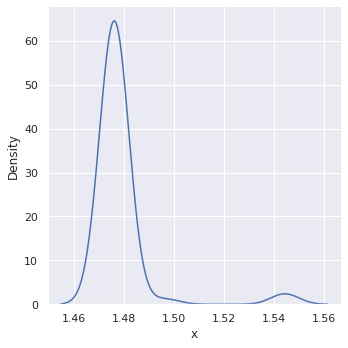

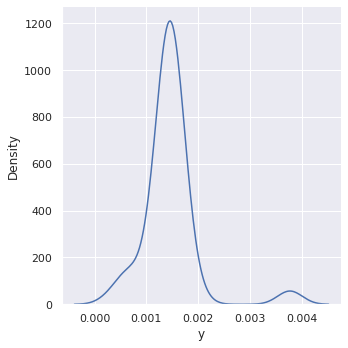

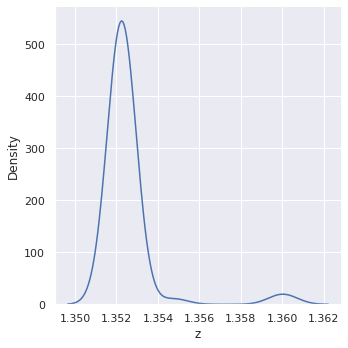

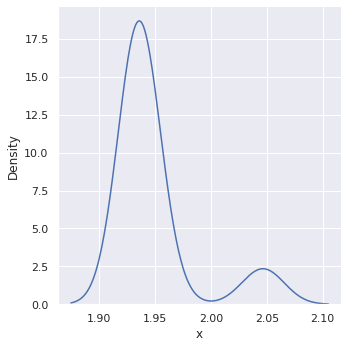

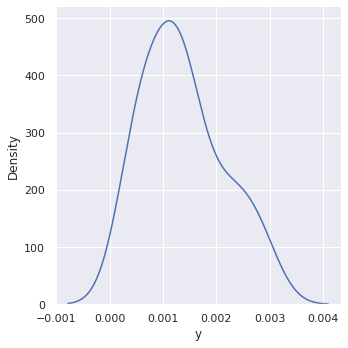

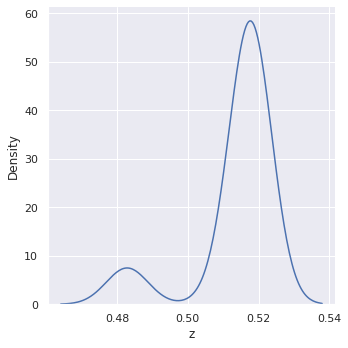

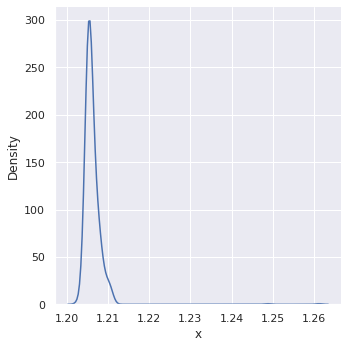

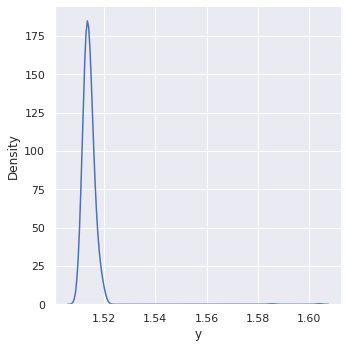

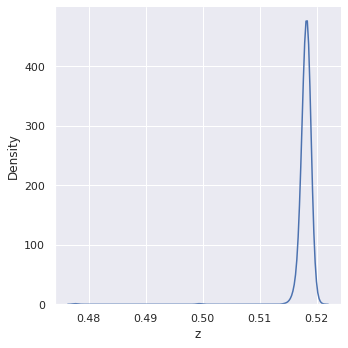

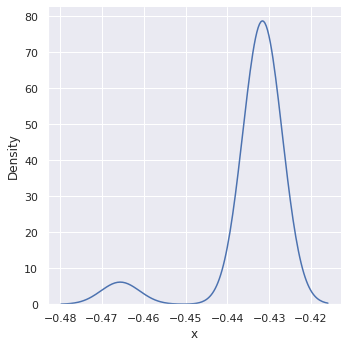

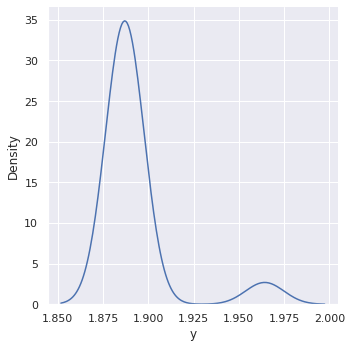

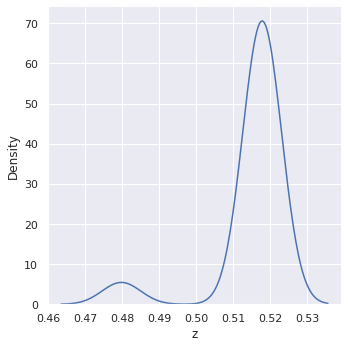

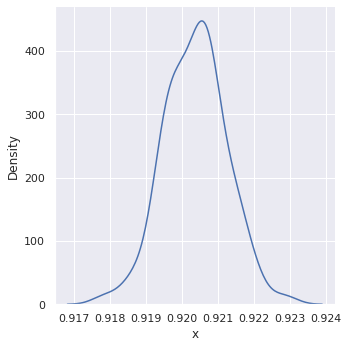

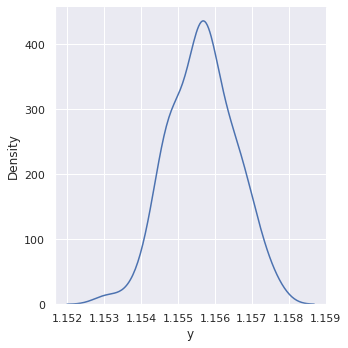

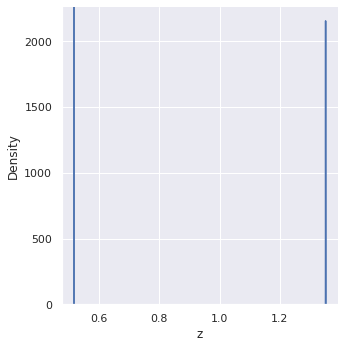

In [143]:
for marker in observations:
    for pos_coordinate in ['x', 'y', 'z']:
        sns.displot(df[df['marker_id']==marker], x=pos_coordinate, kind="kde")
        
# axvlines don't work well with the plot type used by seaborn
plt.axvline(x=nominal_locations[3][0])
plt.axvline(x=nominal_locations_rounded[3][0])

In [146]:
# print the standar deviation for all coordinates
for m in set(marker_id):
    print(f'marker {m}:')
    print(df[df['marker_id']==m].std())
    print('\n')

marker 1:
x            3.561790e-02
y            7.496689e-04
z            1.123683e-02
a            2.348190e-03
b            5.369335e-03
c            1.864367e-03
marker_id    0.000000e+00
xn           4.525488e-16
yn           0.000000e+00
zn           0.000000e+00
an           0.000000e+00
bn           0.000000e+00
cn           0.000000e+00
dtype: float64


marker 2:
x            1.277598e-02
y            5.309579e-04
z            1.470415e-03
a            1.622541e-03
b            3.712732e-03
c            1.186053e-03
marker_id    0.000000e+00
xn           0.000000e+00
yn           0.000000e+00
zn           2.239506e-16
an           0.000000e+00
bn           1.119753e-16
cn           0.000000e+00
dtype: float64


marker 4:
x            2.849899e-03
y            4.464626e-03
z            1.737672e-03
a            2.400401e-03
b            2.354155e-03
c            2.660279e-03
marker_id    0.000000e+00
xn           2.221818e-16
yn           0.000000e+00
zn           0.000000e+00
